# Домашнее задание. Нейросетевая классификация текстов

Задача классификации текстов. Используется датасет [ag_news](https://paperswithcode.com/dataset/ag-news). Это датасет для классификации новостей на 4 темы: "World", "Sports", "Business", "Sci/Tech".

1. Установим модуль datasets, чтобы нам проще было работать с данными.
2. Установим модуль mlflow для логгирования экспериментов. Mlflow поднят на удаленном сервере.

In [1]:
!pip install datasets
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.7/17.7 MB 61.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.5/83.5 kB 7.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.0 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.7-py3-none-any.whl size=143882 sha256=6a6b55bcca7e98f1d40b605f9bcf3f703705758483b37b21cc562fca60a1dc98
  Stored in directory: /root/.cache/pip/wheels/ae/63/93/5402c1a09c1868a59d0b05013484e07af97a9d7b3dbd5bd39a
Successfully built databricks-cli


In [16]:
# Импорт необходимых библиотек и предварительная настройка.

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
import mlflow

from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_0 = user_secrets.get_secret("mlflow_url")

In [3]:
seaborn.set(palette='summer')

nltk.download('punkt')

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


'cuda'

In [4]:
dataset = datasets.load_dataset('ag_news')

Generating train split:   0%|          | 0/120000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/7600 [00:00<?, ? examples/s]

Dataset ag_news downloaded and prepared to /root/.cache/huggingface/datasets/ag_news/default/0.0.0/bc2bcb40336ace1a0374767fc29bb0296cdaf8a6da7298436239c54d79180548. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

## Подготовка данных
Для вашего удобства, мы привели код обработки датасета в ноутбуке. Задача --- обучить модель, которая получит максимальное возможное качество на тестовой части.

* Составим словарь
* Создадим класс WordDataset
* Выделим обучающую и тестовую часть, создадим DataLoader-ы.


In [5]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(
    input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


## Постановка задачи
Ваша задача -- получить максимальное возможное accuracy на `eval_dataloader`. Ниже приведена функция, которую вам необходимо запустить для обученной модели, чтобы вычислить качество её работы.

In [6]:
def evaluate(model, eval_dataloader) -> float:
    """
    Calculate accuracy on validation dataloader.
    """

    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

## RNN v.1.0
Модель для обучения.

In [42]:
class CharLM(nn.Module):
    def __init__(
        self, hidden_dim: int, 
        vocab_size: int, 
        num_classes: int = 4,
        aggregation_type: str = 'max',
        num_layers: int = 1,
        drop_rate = 0.1,
        rnn_type = "rnn"
        ):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        # Заложим возможность менять модель через параметры обучения
        if rnn_type =="gru":
            self.rnn = nn.GRU(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        else:
            self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True, num_layers=num_layers)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=drop_rate)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")
        
        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

Функция для визуализации потерь и точности.

In [45]:
def plot_results(losses, acc):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    axes[0].plot(np.arange(len(losses)), losses)
    axes[0].set_title('Losses')
    axes[0].set_xlabel("epoch")
    axes[1].plot(np.arange(len(acc)), acc)
    axes[1].set_title('Accuracy on val.')
    plt.show()

В train указаны все гиперпараметры, которые предполагается тюнить.

In [40]:
def train(train_dataloader, eval_dataloader, epochs = 5, hidden_dim = 256, num_layers = 1, drop_rate = 0.1, rnn_type="rnn"):
    model = CharLM(hidden_dim=hidden_dim, 
                   num_layers=num_layers, 
                   drop_rate=drop_rate, 
                   vocab_size=len(vocab), 
                   rnn_type=rnn_type).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])
    optimizer = torch.optim.Adam(model.parameters())

    num_epoch = epochs
    eval_steps = len(train_dataloader) // 2


    losses_type = {}
    acc_type = {}

    print(f"{rnn_type} with {num_layers} hidden layers and {drop_rate} dropout for {epochs} epochs...")
    losses = []
    acc = []
    for epoch in range(num_epoch):
        epoch_losses = []
        model.train()
        for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}:')):
            optimizer.zero_grad()
            logits = model(batch['input_ids'])
            loss = criterion(logits, batch['label'])
            loss.backward()
            optimizer.step()

            epoch_losses.append(loss.item())
            if i % eval_steps == 0:
                model.eval()
                acc.append(evaluate(model, eval_dataloader))
                model.train()
        # статистика обучения прокидывается в mlflow на каждой эпохе, т.к. нет возможности передавать их целиком по окончании обучения
        mlflow.log_metric("accuracies", acc[-1])
        losses.append(sum(epoch_losses) / len(epoch_losses))
        mlflow.log_metric("losses", losses[-1])
    model.eval()    
    final_accuracy = evaluate(model, eval_dataloader)
    return losses, acc, final_accuracy 

In [36]:
# Указываем адрес сервера
mlflow.set_tracking_uri(secret_value_0)

## Параметры экспериментов.
List параметров, на каждый эксперимент. Предполгается проверить, как влияет на результат увеличение количества эпох, размер скрытого слоя и dropout. Сравниваются RNN и GRU модели.
Всего предполагается провести 12 экспериментов: 9 на RNN и 3 на GRU.

In [34]:
params = [
    {
        "num_layers": 1,
        "epochs": 5,
        "hidden_dim": 256,
        "drop_rate": 0.1,
        "rnn_type": "rnn"
    },
    {
        "num_layers": 2,
        "epochs": 5,
        "hidden_dim": 256,
        "drop_rate": 0.1,
        "rnn_type": "rnn"
    },
    {
        "num_layers": 3,
        "epochs": 5,
        "hidden_dim": 256,
        "drop_rate": 0.1,
        "rnn_type": "rnn"
    },
    {
        "num_layers": 1,
        "epochs": 5,
        "hidden_dim": 128,
        "drop_rate": 0.1,
        "rnn_type": "rnn"
    },
    {
        "num_layers": 2,
        "epochs": 5,
        "hidden_dim": 128,
        "drop_rate": 0.1,
        "rnn_type": "rnn"
    },
    {
        "num_layers": 3,
        "epochs": 5,
        "hidden_dim": 128,
        "drop_rate": 0.1,
        "rnn_type": "rnn"
    },
    {
        "num_layers": 1,
        "epochs": 5,
        "hidden_dim": 256,
        "drop_rate": 0.3,
        
        
        "rnn_type": "rnn"
    },
    {
        "num_layers": 2,
        "epochs": 5,
        "hidden_dim": 256,
        "drop_rate": 0.3,
        "rnn_type": "rnn"
    },
    {
        "num_layers": 3,
        "epochs": 5,
        "hidden_dim": 256,
        "drop_rate": 0.3,
        "rnn_type": "rnn"
    },
    {
        "num_layers": 2,
        "epochs": 5,
        "hidden_dim": 256,
        "drop_rate": 0.1,
        "rnn_type": "gru"
    },
    {
        "num_layers": 2,
        "epochs": 10,
        "hidden_dim": 256,
        "drop_rate": 0.1,
        "rnn_type": "gru"
    },
    {
        "num_layers": 2,
        "epochs": 5,
        "hidden_dim": 256,
        "drop_rate": 0.3,
        "rnn_type": "gru"
    }
]

При необходимости повторить код без mlflow можно воспользоваться следующим вариантом:
```
for i, param_set in enumerate(params):
    losses, acc, f_acc = train(train_dataloader, eval_dataloader, **param_set)
    print(f"Accuracy: {f_acc}")
    plot_results(losses, acc)
```

In [37]:
for i, param_set in enumerate(params):
    mlflow.set_experiment(experiment_name=f"exp №{i}: {param_set["rnn_type"]}.")
    with mlflow.start_run():
        losses, acc, f_acc = train(train_dataloader, eval_dataloader, **param_set)
        mlflow.log_params(param_set)
        mlflow.log_metric("final accuracy", f_acc)


GRU with 2 hidden layers and 0.1 dropout for 5 epochs...


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

2023/06/04 15:57:47 INFO mlflow.tracking.fluent: Experiment with name 'GRU exp №1.' does not exist. Creating a new experiment.


GRU with 2 hidden layers and 0.1 dropout for 10 epochs...


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 5::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 6::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 7::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 8::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 9::   0%|          | 0/3750 [00:00<?, ?it/s]

2023/06/04 16:17:28 INFO mlflow.tracking.fluent: Experiment with name 'GRU exp №2.' does not exist. Creating a new experiment.


GRU with 2 hidden layers and 0.3 dropout for 5 epochs...


Training epoch 0::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 1::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 2::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 3::   0%|          | 0/3750 [00:00<?, ?it/s]

Training epoch 4::   0%|          | 0/3750 [00:00<?, ?it/s]

## Результаты
---
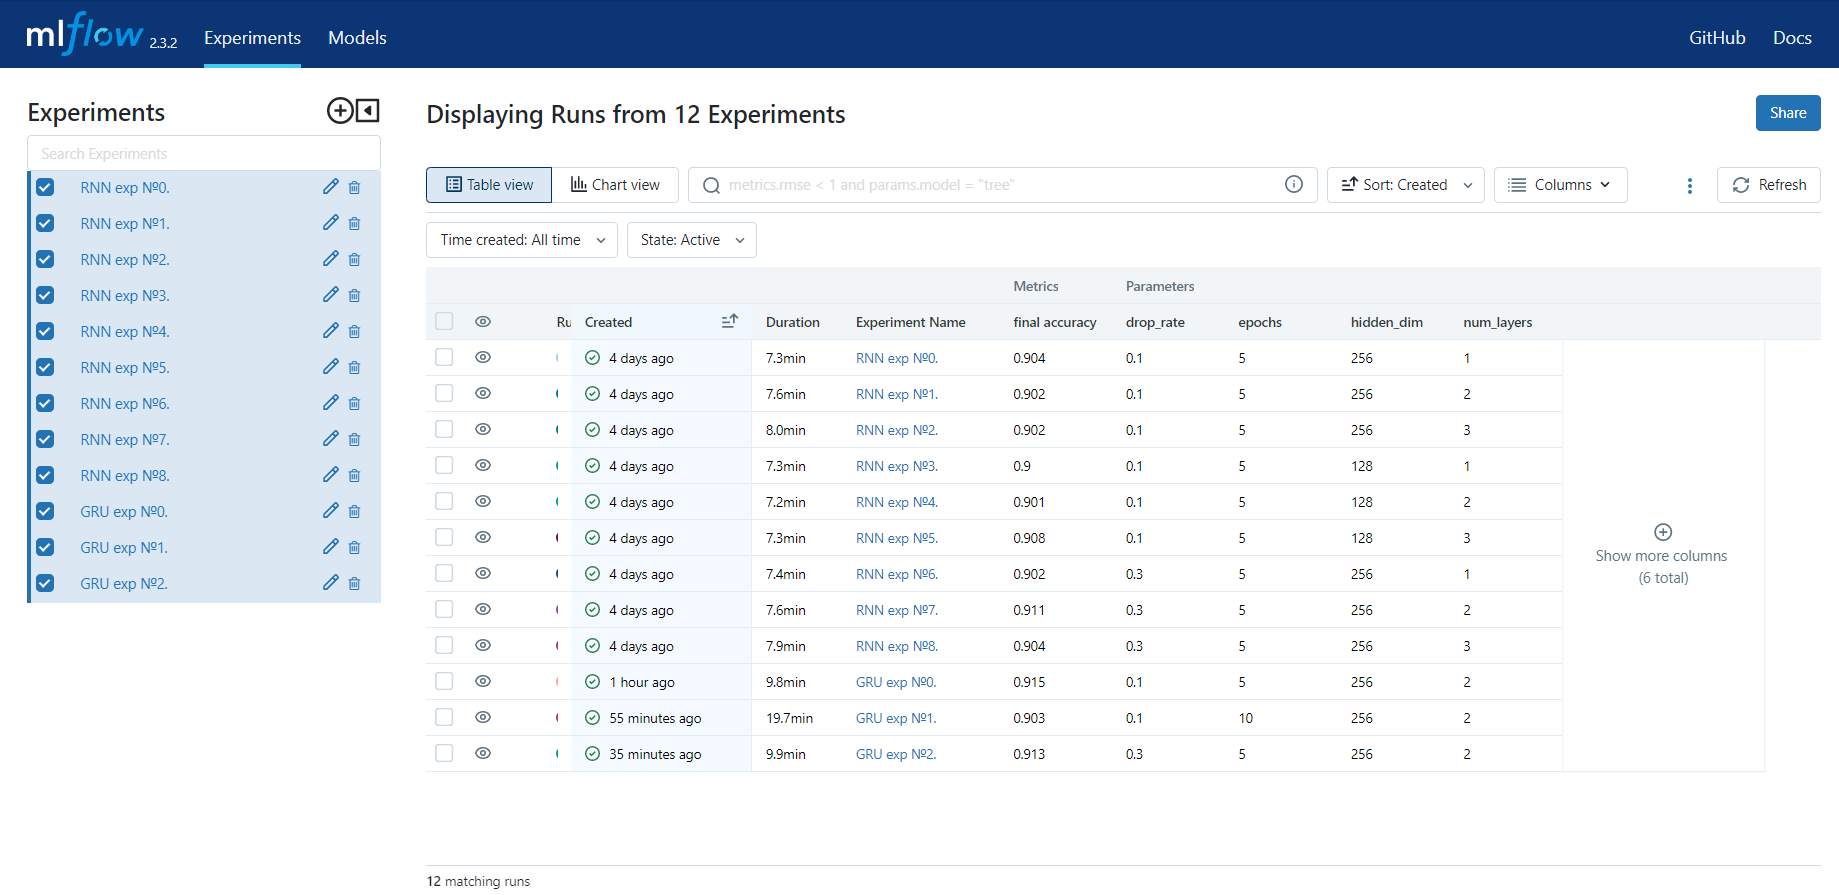
Базовый вариант ("RNN exp. №0") дал точность 0.904. Измения гиперпараметров почти ни влияли на этот показатель: добавление скрытых слоев и их размер не давали значительного прироста в качестве. Однако большой прирост дал dropout.
Блок экспериментов по RNN проводился отдельно, чтобы выявить значимые параметры.
Как следствие, на GRU изменялся только Dropout и количество эпох.

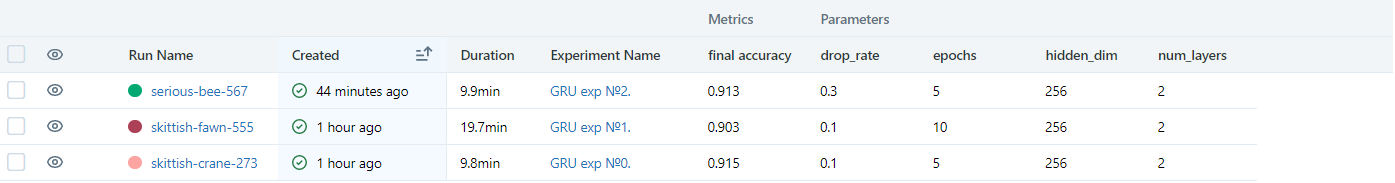

Как видно из указанной статистики, при большем количестве эпох модель переобучается и начинается падение качества. Вот график **Accuracy** для второго эксперимента, длившегося 10 эпох (в mlflow по оси Х откладывается относительное время записи логов, соотв. эпоха=точка):
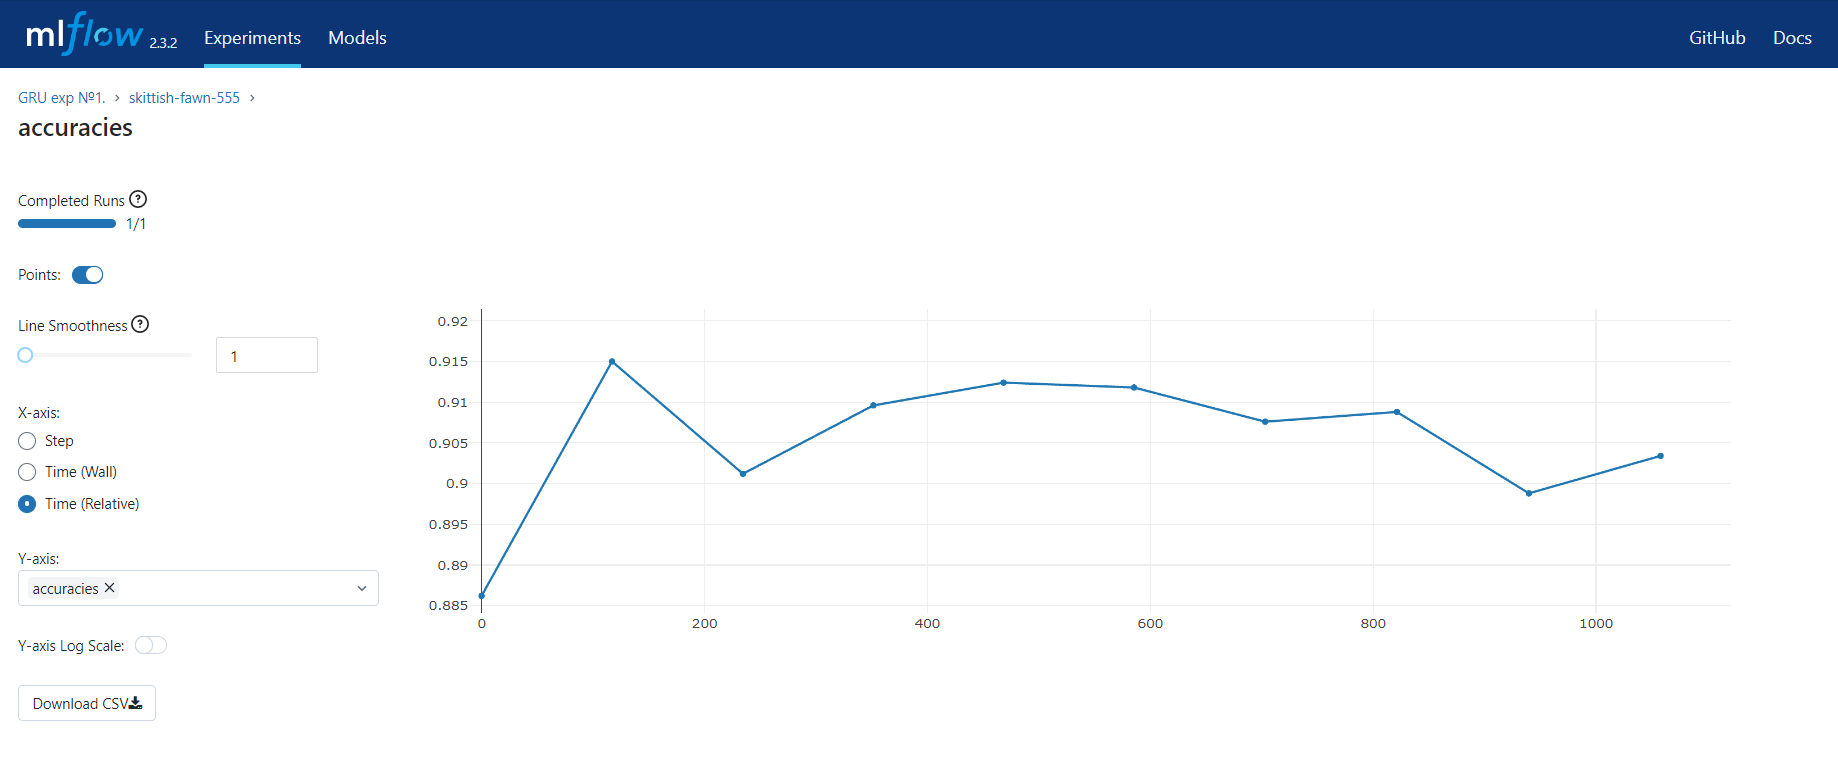
Как видно, кроме переобучения, сходимость не стабильна, особенно на первых этапах обучения. Однако dropout решает эту проблему, как видно из графика точности ниже:
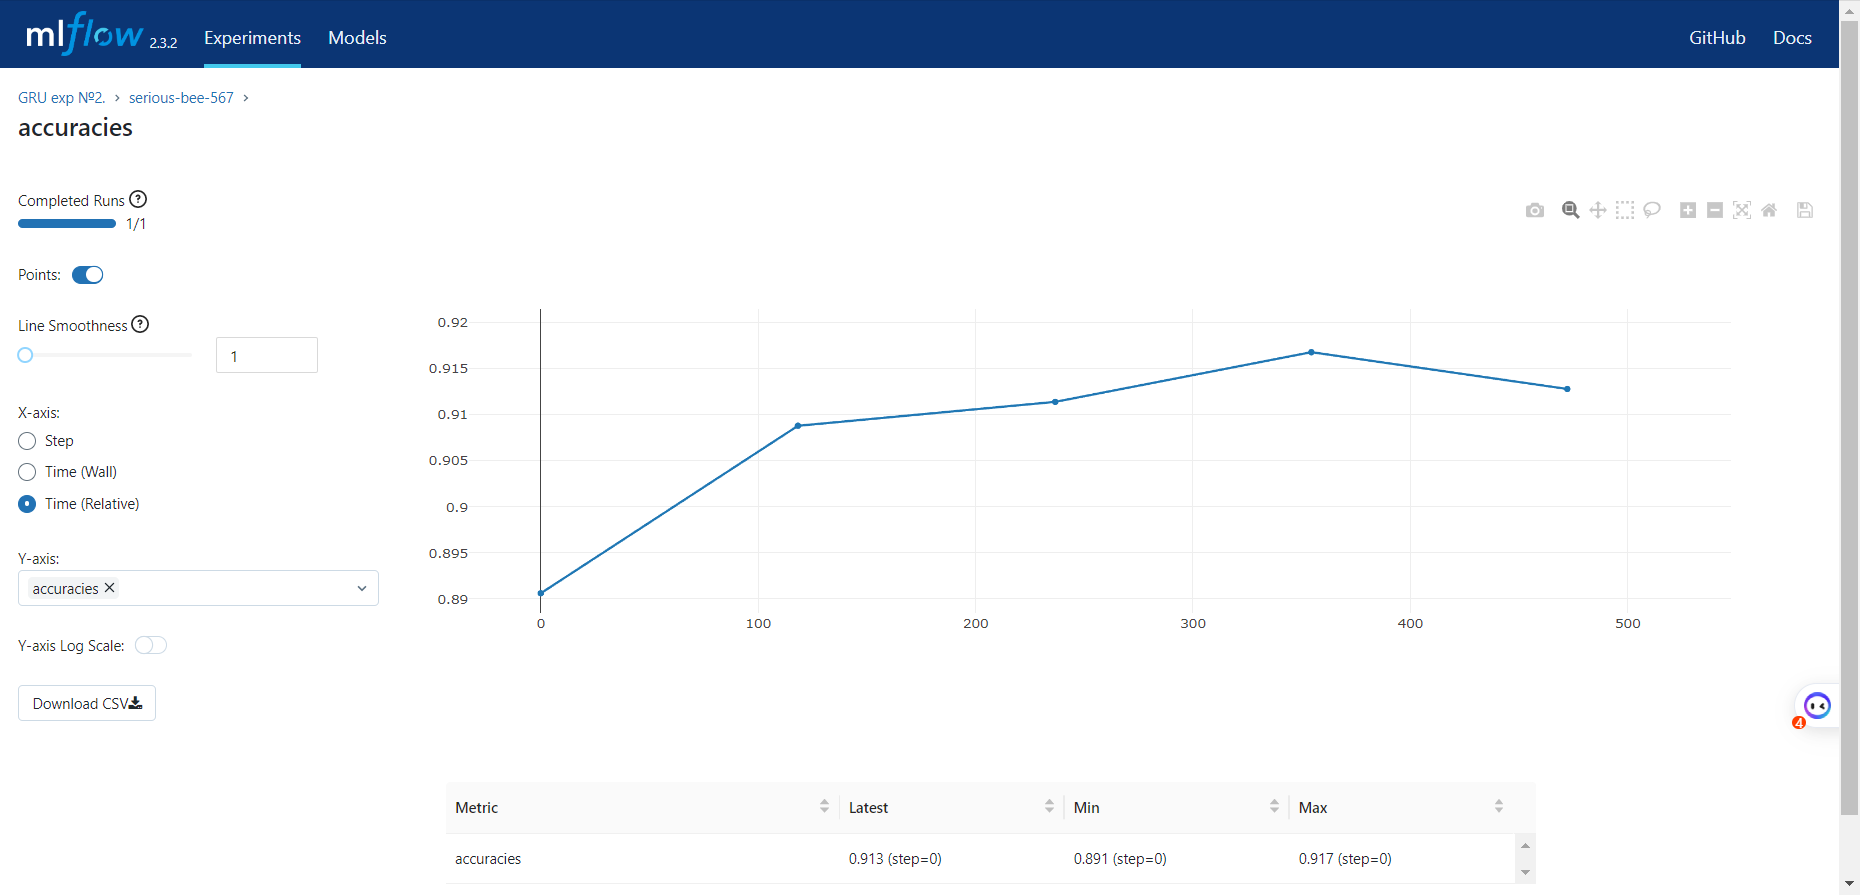

#### Соотв. Финальный эксперимент: 10 эпох на GRU с дропаутом 0.3.

Accuracy: 0.9089999794960022


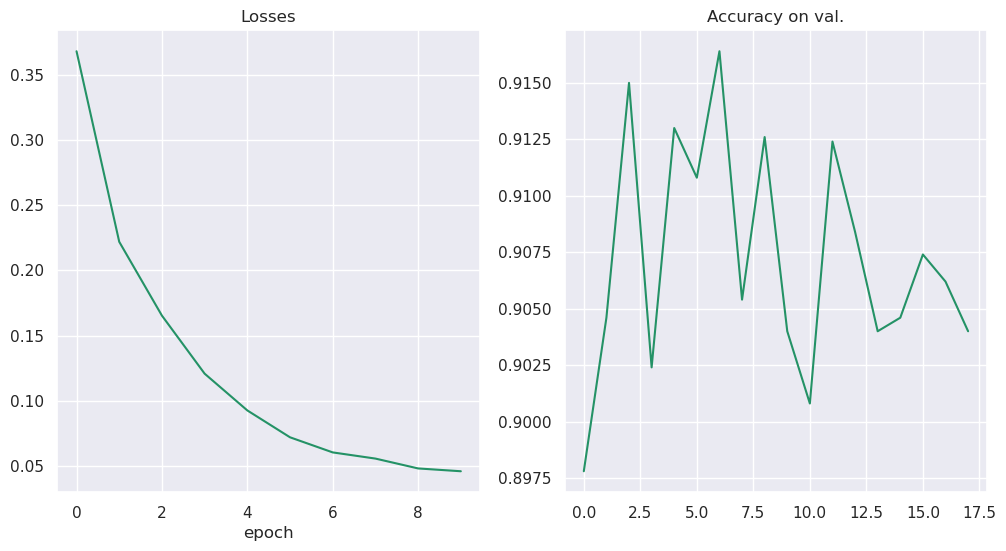

In [48]:
param_set = {
        "num_layers": 2,
        "epochs": 10,
        "hidden_dim": 256,
        "drop_rate": 0.3,
        "rnn_type": "gru"
    }
losses, acc, f_acc = train(train_dataloader, eval_dataloader, **param_set)
print(f"Accuracy: {f_acc}")
plot_results(losses, acc[2:])

*Здесь точность считается  раз в два батча trainloader как на семинаре - в mlflow сохраняется меньше значений.

Заключение.
---
#### Как видно, стабильной сходимости все равно нет. Таким образом, наилучшей моделью остается **GRU обученая 5 эпох, с 2 слоями и 0.1 dropout**.